# Experiment Analysis

This notebook is used to analyze the results of certain experiments which can be found in the pycomex experiment archive located at the ``RESULTS_PATH`` directory.

In [2]:
import os
import time
import json
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from rich.pretty import pprint
from pycomex.utils import is_experiment_archive
from pycomex.utils import render_string_table
from pycomex.functional.experiment import Experiment

# This will be the path to the directory in which the notebook is located.
PATH: str = os.getcwd()
# This will have to be the path to the pycomex "results" directory containing the 
# experiment archives of interest.
# HAS TO BE CHANGED, if the analysis is not located in the same directory as the results
# folder.
RESULTS_PATH: str = os.path.join(PATH, 'results')
RESULTS_PATH

'/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results'

In [3]:

# Filter which experiments will be loaded based on their name and/or parameters.
def select_experiment(experiment_name: str,
                      experiment_metadata: dict,
                      experiment_parameters: dict
                      ) -> bool:
    return '__PREFIX__' in experiment_parameters and 'ex_01_aa' in experiment_parameters['__PREFIX__']


# Assign a unique key to the experiment based on its data / parameters etc.
# Later on the experiments will be sorted based on this key which will be the 
# key of a dictionary and the values will be a list of all the experiments with 
# that same key.
def sort_experiment(experiment: Experiment) -> tuple:
    
    *_, encoding, dataset = experiment.metadata['name'].split('__')
    method = experiment.parameters['MODELS'][0]
    
    if 'FINGERPRINT_TYPE' in experiment.parameters:
        encoding = experiment.parameters['FINGERPRINT_TYPE']
        
    if '_hdc' in experiment.metadata['name']:
        encoding = 'hdc'
        
    if 'NOTE' in experiment.parameters:
        dataset = experiment.parameters['NOTE']
    
    return (encoding, dataset, method)

### Experiment Discovery

The following cell will first discover all of the previously executed experiment runs which have been archived in the given results directory. It will then print the number of experiments found.

In [4]:
# This list will contain the paths to the individual expeirment *namespaces* which in 
# turn contain the actual individual experiment archives.
experiment_namespace_paths: list[str] = [
    path
    for file_name in os.listdir(RESULTS_PATH)
    if os.path.isdir(path := os.path.join(RESULTS_PATH, file_name))
]

# Subsequently, this list will contain the paths to the individual experiment archives
# folders.
experiment_paths: list[str] = []
for namespace_path in experiment_namespace_paths:
    for dirpath, dirnames, filenames in os.walk(namespace_path):
        if is_experiment_archive(dirpath):
            experiment_paths.append(dirpath)
            dirnames.clear() # Prevents further recursion into subdirectories
        
print(f'✅ found {len(experiment_paths)} experiment archives in {len(experiment_namespace_paths)} namespaces')
pprint(experiment_paths, max_length=3)

✅ found 30202 experiment archives in 38 namespaces


[
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/ex_01_a__10_01_2025__18_29__6zGY',
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/debug',
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/ex_01_a__10_01_2025__18_32__Sozn',
│   ... +30199
]

### Experiment Loading

The following cell will then load the experiment runs into memory selectively based on the previously defined ``select_experiment`` function. Only experiments for which the function returns ``True`` will be loaded into memory. The loaded experiments will actually be restored from the archive by loading the parameters as well as the data back into a ``pycomex.experiment.Experiment`` object.

In [5]:
# This list will be populated with the actual Experiment instances which will 
# be loaded from the experiment archive folders.
experiments: list[Experiment] = []

print(f'Loading experiments from archives...')
print(f'Iterating over {len(experiment_paths)} experiment paths')
time_start: float = time.time()
for experiment_path in experiment_paths:
    
    experiment_identifier: str = os.path.basename(experiment_path)
    
    experiment_data_path = os.path.join(experiment_path, Experiment.DATA_FILE_NAME)
    if not os.path.exists(experiment_data_path):
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no data found')
        continue
    
    experiment_meta_path = os.path.join(experiment_path, Experiment.METADATA_FILE_NAME)
    if not os.path.exists(experiment_meta_path):
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no metadata found')
        continue
    
    with open(experiment_meta_path) as file:
        content = file.read()
        # This will contain the experiment metadata as a dictionary which we can now use to
        # filter for instance.
        experiment_metadata: dict = json.loads(content)
        
    if 'parameters' not in experiment_metadata:
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no parameters found')
        continue
    
    experiment_parameters: dict = {
        param: info['value']
        for param, info in experiment_metadata['parameters'].items()
        if 'value' in info
    }
    
    # Here we apply the filter to determine whether or not the experiment should be included
    # in the analysis.
    condition: bool = select_experiment(
        experiment_name=experiment_metadata['name'],
        experiment_metadata=experiment_metadata,
        experiment_parameters=experiment_parameters
    )
    
    if condition:
        try:
            print(f'   > included experiment "{experiment_identifier}"')
            experiment: Experiment = Experiment.load(experiment_path)
            experiments.append(experiment)
        except Exception as e:
            print(f'   ⚠️ Failed to load experiment "{experiment_identifier}" - Exception: {e}')
    
            
time_end: float = time.time()
duration: float = time_end - time_start
print(f'✅ Loaded {len(experiments)} experiments in {duration:.2f} seconds')

Loading experiments from archives...
Iterating over 30202 experiment paths
   ⚠️ Skipping experiment "debug" - no data found
   > included experiment "ex_01_aa__26_09_2025__16_46__shX9"


/media/ssd2/Programming/graph_hdc/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   > included experiment "ex_01_aa__26_09_2025__13_02__tIXW"
   > included experiment "ex_01_aa__26_09_2025__13_20__vN1k"
   ⚠️ Skipping experiment "ex_00_c__17_08_2025__16_08__JXbr" - no data found
   > included experiment "ex_01_aa__26_09_2025__14_30__Mk5s"
   > included experiment "ex_01_aa__26_09_2025__15_47__x0jt"
   > included experiment "ex_01_aa__26_09_2025__15_48__LjKX"
   > included experiment "ex_01_aa__26_09_2025__15_09__KVFr"
   > included experiment "ex_01_aa__26_09_2025__13_25__NJ6l"
   > included experiment "ex_01_aa__26_09_2025__14_49__9roa"
   > included experiment "ex_01_aa__26_09_2025__16_42__kRqm"
   > included experiment "ex_01_aa__26_09_2025__14_26__mAT1"
   > included experiment "ex_01_aa__26_09_2025__15_04__xaKB"
   > included experiment "ex_01_aa__26_09_2025__15_09__DOe4"
   > included experiment "ex_01_aa__26_09_2025__14_54__IvGr"
   > included experiment "ex_01_aa__26_09_2025__15_57__BvL1"
   > included experiment "ex_01_aa__26_09_2025__16_50__YWFP"
   > inc

In [6]:
example_experiment: Experiment = experiments[0] if experiments else None
print(f'{len(experiments)} experiments loaded')
pprint(example_experiment.data, max_length=10)

1120 experiments loaded


{
│   'indices': {
│   │   'train': [5503, 6675, 6280, 2377, 309, 5144, 4226, 7124, 6620, 5224, ... +8000],
│   │   'val': [1915, 3945, 206, 5883, 7243, 1303, 442, 6598, 2880, 8169, ... +879],
│   │   'test': [9403, 1320, 7948, 4286, 603, 7, 2385, 9610, 7706, 6113, ... +978]
│   },
│   'metrics': {
│   │   'test_k_neighbors': {'r2': 0.7072037679435782, 'mse': 10.10830506120707, 'mae': 1.3615877840516553}
│   }
}

### Experiment Sorting

The following cell will sort the - currently still unsorted - experiment list by a custom criteria defined in the ``sort_experiments`` function. This is done by putting all the experiments into the same list for which this function returns the same index tuple. The result is the ``key_experiment_map`` dictionary data structure which maps the index tuple to a list of experiments.

In [7]:
# This will be a dictionary mapping the unique key of the experiment to a list of
# experiments which share that key. This will allow us to group experiments based on
# their parameters or other attributes.
key_experiment_map: dict[tuple, list[Experiment]] = defaultdict(list)

for experiment in experiments:
    key: tuple = sort_experiment(experiment)
    key_experiment_map[key].append(experiment)
    
key_experiment_map = dict(sorted(key_experiment_map.items(), key=lambda item: item[0][0] + item[0][1] + item[0][2])) 
pprint(key_experiment_map, max_length=5)

{
│   ('gnn', 'aqsoldb', 'gatv2'): [
│   │   <pycomex.functional.experiment.Experiment object at 0x725923573550>,
│   │   <pycomex.functional.experiment.Experiment object at 0x725923059e10>,
│   │   <pycomex.functional.experiment.Experiment object at 0x7259236dc190>,
│   │   <pycomex.functional.experiment.Experiment object at 0x725923533b90>,
│   │   <pycomex.functional.experiment.Experiment object at 0x725923459750>,
│   │   ... +5
│   ],
│   ('gnn', 'clogp', 'gatv2'): [
│   │   <pycomex.functional.experiment.Experiment object at 0x7259239ce550>,
│   │   <pycomex.functional.experiment.Experiment object at 0x725923577e90>,
│   │   <pycomex.functional.experiment.Experiment object at 0x725923407f10>,
│   │   <pycomex.functional.experiment.Experiment object at 0x725923473e10>,
│   │   <pycomex.functional.experiment.Experiment object at 0x725923303d50>,
│   │   ... +5
│   ],
│   ('gnn', 'qm9_energy', 'gatv2'): [
│   │   <pycomex.functional.experiment.Experiment object at 0x72591defbcd0>,
│   │   <pycomex.functional.experiment.Experiment object at 0x72591db0ce90>,
│   │   <pycomex.functional.experiment.Experiment object at 0x72591dbae250>,
│   │   <pycomex.functional.experiment.Experiment object at 0x72591db43c50>,
│   │   <pycomex.functional.experiment.Experiment object at 0x72591dbd0f50>,
│   │   ... +5
│   ],
│   ('gnn', 'qm9_gap', 'gatv2'): [
│   │   <pycomex.functional.experiment.Experiment object at 0x72591de6d110>,
│   │   <pycomex.functional.experiment.Experiment object at 0x72591de6ad10>,
│   │   <pycomex.functional.experiment.Experiment object at 0x72591e58abd0>,
│   │   <pycomex.functional.experiment.Experiment object at 0x72591daf6090>,
│   │   <pycomex.functional.experiment.Experiment object at 0x72591da7f350>,
│   │   ... +5
│   ],
│   ('hdc', 'aqsoldb', 'grad_boost'): [
│   │   <pycomex.functional.experiment.Experiment object at 0x72591fc06490>,
│   │   <pycomex.functional.experiment.Experiment object at 0x72591f00dc90>,
│   │   <pycomex.functional.experiment.Experiment object at 0x72591f1af150>,
│   │   <pycomex.functional.experiment.Experiment object at 0x72591f136290>,
│   │   <pycomex.functional.experiment.Experiment object at 0x72591f735cd0>,
│   │   ... +5
│   ],
│   ... +107
}

### Experiment Result Table

The following cell illustrates how to create a table from the aggregated results of many loaded experiments, which is a common use case of the analysis.

In [8]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Encoding', 'Dataset', 'Method', 'Result']

# This data structure will hold the (encoding, dataset, method) tuple as keys and the metric
# values as a list value.
key_values_map = defaultdict(list)

for (encoding, dataset, method), _experiments in key_experiment_map.items():
    
    example_experiment = _experiments[0]
    if example_experiment.parameters['DATASET_TYPE'] == 'regression':
        metric = 'r2'
    else:
        metric = 'f1'
        
    values = [exp.data['metrics'][f'test_{method}'][metric] for exp in _experiments if 'metrics' in exp.data]
    mean_value = np.mean(values)
    std_value = np.std(values)
    
    table.add_row([
        encoding,
        dataset,
        method,
        f'{mean_value:.2f} ± {std_value:.2f}',
    ])
    
    key_values_map[(encoding, dataset, method)] = values
    
print(table.get_string())

+-------------------+---------------+---------------+--------------+
|      Encoding     |    Dataset    |     Method    |    Result    |
+-------------------+---------------+---------------+--------------+
|        gnn        |    aqsoldb    |     gatv2     | 0.85 ± 0.01  |
|        gnn        |     clogp     |     gatv2     | 0.99 ± 0.00  |
|        gnn        |   qm9_energy  |     gatv2     | 1.00 ± 0.00  |
|        gnn        |    qm9_gap    |     gatv2     | 0.93 ± 0.01  |
|        hdc        |    aqsoldb    |   grad_boost  | 0.50 ± 0.02  |
|        hdc        |    aqsoldb    |  k_neighbors  | 0.76 ± 0.02  |
|        hdc        |    aqsoldb    |   neural_net  | 0.84 ± 0.01  |
|        hdc        |    aqsoldb    |  neural_net2  | 0.85 ± 0.01  |
|        hdc        |    aqsoldb    | random_forest | 0.78 ± 0.01  |
|        hdc        |    bace_reg   |   grad_boost  | 0.39 ± 0.02  |
|        hdc        |    bace_reg   |  k_neighbors  | 0.64 ± 0.05  |
|        hdc        |    bace_reg 

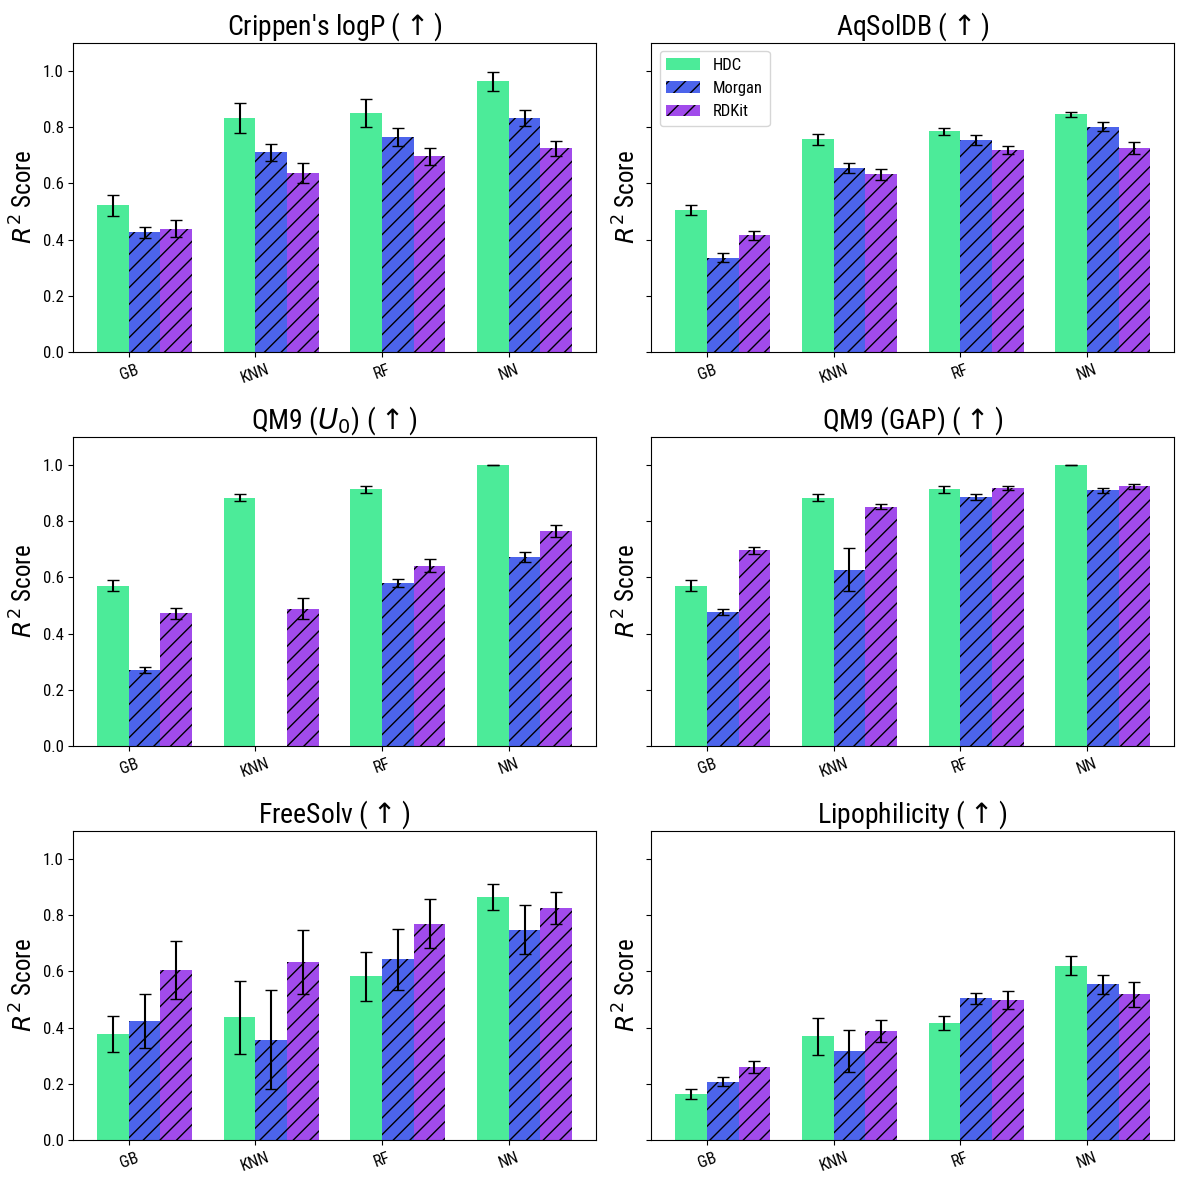

In [14]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Control whether GNN baseline (GATv2) should be displayed as a horizontal line
SHOW_GNN: bool = False

# ============================================================================
# MATPLOTLIB STYLING
# ============================================================================

plt.style.use('default')
plt.rcParams['font.family'] = 'Roboto Condensed'

# ============================================================================
# DATASET SELECTION
# ============================================================================

# List of regression datasets to include in the visualization
# All selected datasets are molecular property prediction tasks where higher R² is better
datasets = [
    'clogp',           # Crippen's logP - lipophilicity prediction
    'aqsoldb',         # Aqueous solubility prediction
    'qm9_energy',      # QM9 internal energy (U₀) prediction
    'qm9_gap',         # QM9 HOMO-LUMO gap prediction
    'freesolv',        # Hydration free energy prediction
    'lipophilicity',   # Lipophilicity prediction
    # Commented out: additional regression tasks not included in this analysis
    #'bace_reg',       # BACE regression task
    # Commented out: classification datasets (would require different metrics)
    #'qm9_smiles',     
    #'conjugated',     
    #'bbbp',           
    #'ames'
]

# ============================================================================
# METHOD SELECTION
# ============================================================================

# Machine learning methods to compare across different encodings
methods = [
    'grad_boost',      # Gradient Boosting - ensemble method
    'k_neighbors',     # K-Nearest Neighbors - instance-based learning
    'random_forest',   # Random Forest - ensemble of decision trees
    'neural_net2',     # Neural Network - deep learning baseline
    # Commented out: simpler methods that performed poorly or are redundant
    #'linear',         # Linear regression (too simple for these tasks)
    #'neural_net',     # Earlier NN implementation (replaced by neural_net2)
]

# ============================================================================
# ENCODING TYPES
# ============================================================================

# Molecular encoding methods to compare
# Note: GNN is NOT included here as it's treated specially (shown as horizontal baseline)
encodings = [
    'hdc',             # Hyperdimensional Computing encoding (our novel approach)
    'morgan',          # Morgan fingerprint (circular fingerprint baseline)
    'rdkit',           # RDKit fingerprint (traditional topological fingerprint)
    # Commented out: generic fingerprint label (replaced by specific types)
    #'fp'              
]

# ============================================================================
# VISUALIZATION SETTINGS
# ============================================================================

# Color scheme for each encoding type
# HDC uses green, traditional fingerprints use shades of blue/purple
colors = {
    'hdc': "#4CEB99",      # Green - highlights our novel HDC approach
    'fp': "#4C64EB",       # Blue - generic fingerprint
    'morgan': '#4C64EB',   # Blue - Morgan fingerprint
    'rdkit': '#A14BEB'     # Purple - RDKit fingerprint
}

# Hatch pattern mapping to visually distinguish encoding types
# HDC bars are solid (no hatch), traditional fingerprints use diagonal lines
# This provides additional visual distinction beyond color
hatched = {
    'hdc': False,          # Solid bars for HDC
    'fp': True,            # Hatched bars for generic fingerprint
    'morgan': True,        # Hatched bars for Morgan
    'rdkit': True          # Hatched bars for RDKit
}

# ============================================================================
# LABEL MAPPINGS
# ============================================================================

# Human-readable labels for encodings (used in plot legends)
encoding_label_map = {
    'hdc': 'HDC',
    'fp': 'FP',
    'gnn': 'GNN',          # GNN label (for special baseline display)
    'morgan': 'Morgan',
    'rdkit': 'RDKit',
}

# Human-readable labels for datasets with arrow notation
# ↑ indicates that higher values are better (for all regression metrics here)
dataset_label_map = {
    'clogp': r"Crippen's logP ($\uparrow$)",
    'aqsoldb': r'AqSolDB ($\uparrow$)',
    'qm9_smiles': r'QM9 (GAP) ($\uparrow$)',
    'conjugated': r'Conjugated ($\uparrow$)',
    'bbbp': r'BBBP ($\uparrow$)',
    'ames': r'Mutagenicity ($\uparrow$)',
    'qm9_gap': r'QM9 (GAP) ($\uparrow$)',
    'qm9_energy': r'QM9 ($U_0$) ($\uparrow$)',
    'bace_reg': r'BACE Regression ($\uparrow$)',
    'freesolv': r'FreeSolv ($\uparrow$)',
    'lipophilicity': r'Lipophilicity ($\uparrow$)',
}

# Human-readable abbreviations for machine learning methods
method_label_map = {
    'grad_boost': 'GB',
    'k_neighbors': 'KNN',
    'neural_net2': 'NN',
    'random_forest': 'RF',
    # Commented out: methods not included in this analysis
    #'linear': 'LR',
    #'neural_net': 'NN',
}

# ============================================================================
# FIGURE CREATION
# ============================================================================

# Create subplots: 3 rows × 2 columns for up to 6 datasets
# sharey=True ensures all subplots share the same y-axis scale
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey=True)
axes = axes.flatten()
plt.rcParams.update({'font.size': 12})

# ============================================================================
# PLOTTING LOGIC
# ============================================================================

for i, dataset in enumerate(datasets):
    ax = axes[i]
    
    # Bar positioning: space methods along x-axis
    bar_positions = np.arange(len(methods))
    width = 0.25  # Bar width (allows 3-4 encodings to fit side-by-side)

    # Plot bars for each encoding type
    for j, encoding in enumerate(encodings):
        means = []
        stds = []
        
        # Collect mean and std for each method with this encoding
        for method in methods:
            vals = key_values_map.get((encoding, dataset, method), [])
            means.append(np.mean(vals) if vals else np.nan)
            stds.append(np.std(vals) if vals else np.nan)
        
        # Apply hatch pattern for traditional fingerprints, solid for HDC
        hatch_pattern = '//' if hatched.get(encoding, False) else None
        
        # Plot grouped bars: offset each encoding by width to group by method
        ax.bar(
            bar_positions + (j-0.5)*width,  # Offset bars for side-by-side display
            means,
            width=width,
            yerr=stds,                      # Error bars showing standard deviation
            label=encoding_label_map.get(encoding, encoding),
            color=colors[encoding],
            capsize=4,                       # Error bar cap size
            hatch=hatch_pattern,
        )

    # ========================================================================
    # GNN BASELINE (SPECIAL TREATMENT)
    # ========================================================================
    
    # GNN is displayed as a horizontal dashed line for comparison
    # This is because GNN uses a different architecture and isn't grouped with
    # the fingerprint-based methods
    if SHOW_GNN:
        gnn_vals = key_values_map.get(('gnn', dataset, 'gatv2'), [])
        if gnn_vals:
            gnn_mean = np.mean(gnn_vals)
            # Draw horizontal line at GNN performance level
            ax.axhline(gnn_mean, color='black', linestyle='--')
            # Annotate with GNN score
            ax.text(
                len(methods)-0.5,
                gnn_mean + 0.03,
                f'gatv2: {gnn_mean:.2f}',
                va='bottom',
                ha='right',
                color='black',
                fontsize=16
            )

    # ========================================================================
    # SUBPLOT FORMATTING
    # ========================================================================
    
    # Set x-axis labels with method abbreviations
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([method_label_map.get(m, m) for m in methods], rotation=20)
    
    # Set subplot title and labels
    ax.set_title(dataset_label_map.get(dataset, dataset))
    ax.set_ylabel('$R^2$ Score')
    
    # Show legend only on second subplot to avoid redundancy
    if i == 1:
        ax.legend()

# ============================================================================
# FINAL FIGURE ADJUSTMENTS
# ============================================================================

# Hide unused subplots (if fewer than 6 datasets are selected)
for j in range(len(datasets), len(axes)):
    axes[j].set_visible(False)

# Set consistent y-axis limits across all plots
ax.set_ylim(0.0, 1.1)  # R² scores range from 0 to 1, add margin for annotations

# Format all visible subplots with consistent font sizes
for ax in axes[:len(datasets)]:
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.title.set_size(20)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig('ex_01_plot.pdf', bbox_inches='tight')
plt.show()